This code shows how to manipulate the instruments and collect data from the Clement's architecture.

Let's first start by importing the useful libraries.

In [15]:
import matplotlib.pyplot as plt
import pyvisa as visa
import nidaqmx
import time
import numpy as np

Each of the library will be used in the following paragraphs.
The, we deifine the parameters for the rest of the code.

In [16]:
F_NIDAQ = 500000 # Hz
N_CHANNEL = 10 # Number of channel
F_CHANNEL =  F_NIDAQ/N_CHANNEL # Frequency per channel that is used
V_PI_PM = 8 # Voltage for PI phase shift; see the specs of the phase modulator

Let's first work on the phase modulator by collecting the data from output 16 and 17.
We connect and find the appropriate AWG.

In [17]:
rm=visa.ResourceManager()
li=rm.list_resources()
for index in range(len(li)):
    print(str(index)+" - "+li[index])
# choice = input("Which device?: ")
choice = 6
vi=rm.open_resource(li[int(choice)])

0 - USB0::0xF4EC::0xEE38::516L19115::INSTR
1 - ASRL3::INSTR
2 - ASRL1::INSTR
3 - ASRL7::INSTR
4 - ASRL9::INSTR
5 - ASRL6::INSTR
6 - USB0::0xF4EC::0xEE38::516L19115::INSTR


Print the information of the device.

In [18]:
print(vi.query("*idn?"))

BK,4055B,516L19115,1.01.01.33R1B3



We configure the device's channel as being a DC waveform.

In [19]:
print("Configuring C1")
vi.write("c2:bswv wvtp,dc")
vi.write("c2:output on")
print(vi.query("c2:bswv?"))

Configuring C1
C2:BSWV WVTP,DC,OFST,3.5V



Now the device's channel is set to DC voltage and that can be changed with the following command line.
We set the voltage to 0V.

In [20]:

vi.write("c2:bswv ofst,3.5")
print(vi.query("c2:bswv?"))

C2:BSWV WVTP,DC,OFST,3.5V



Now, let's set the NIDAQ and read the channel 16 and 17. Let's start by instantiating the NIDAQ and read out the output voltage and current 16/17 of the Nidaq.

Freq is : 12132.820748685996
[[0.37989862668789565, 0.3805567733875403, 0.3803922367125364, 0.3803922367125364, 0.3802277000375944, 0.3803922367125364, 0.3802277000375944, 0.3803922367125364, 0.3800631633627141, 0.3802277000375944, 0.37989862668789565, 0.3800631633627141, 0.37989862668789565, 0.3800631633627141, 0.37989862668789565, 0.37973409001313896, 0.3800631633627141, 0.3800631633627141, 0.3800631633627141, 0.3800631633627141, 0.37989862668789565, 0.3800631633627141, 0.37973409001313896, 0.3800631633627141, 0.3803922367125364, 0.3802277000375944, 0.3802277000375944, 0.3803922367125364, 0.3803922367125364, 0.3803922367125364, 0.3803922367125364, 0.3800631633627141, 0.3802277000375944, 0.3803922367125364, 0.3803922367125364, 0.3805567733875403, 0.3803922367125364, 0.3803922367125364, 0.3803922367125364, 0.3803922367125364, 0.3805567733875403, 0.3803922367125364, 0.3805567733875403, 0.3803922367125364, 0.3805567733875403, 0.3803922367125364, 0.3803922367125364, 0.3803922367125364, 0.

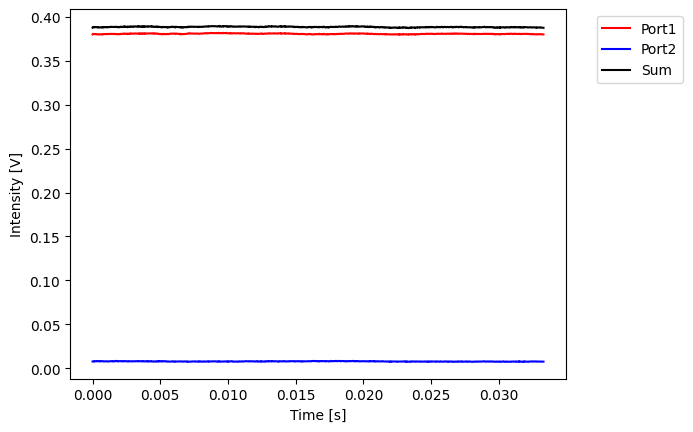

In [21]:
DATA = [[] for i in range(2)]
SamplingRate = 30000
for i in range(1):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai16")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai17")
        task.timing.cfg_samp_clk_timing(rate = SamplingRate
            
        )
        sample = 1000
        start_time = time.time()
        voltage_data =task.read(number_of_samples_per_channel=sample)
        end_time = time.time()
        frequence = sample/(end_time-start_time)
        print("Freq is :",frequence)
        print(voltage_data)
#voltage_data = voltage_data[13700:14000]
SUM = [i+j for i,j in zip(voltage_data[0],voltage_data[1])]
TIME = [i/SamplingRate for i in range(sample)]
plt.plot(TIME,voltage_data[0],color ="red",label = "Port1")
plt.plot(TIME,voltage_data[1],color ="blue",label = "Port2")
plt.plot(TIME,SUM,color="black",label = "Sum")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), ncol=1)
plt.xlabel("Time [s]")
plt.ylabel("Intensity [V]")
plt.show()



Now, let's take the Fourier transform of the plot.

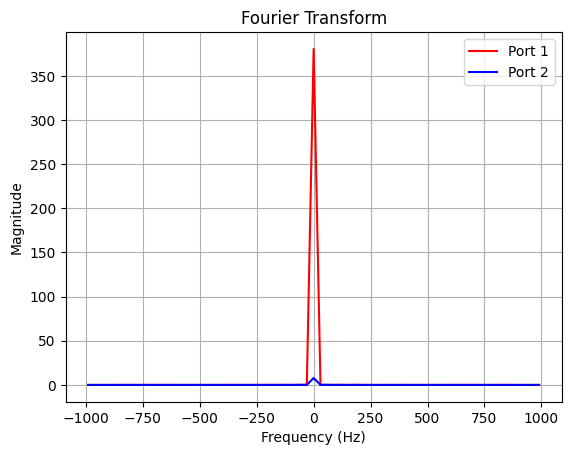

In [22]:
def plot_fourier_transform(DATA, sample_rate):
    colors = ["red", "blue"]
    index = 0
    for data in DATA:
        # Compute the Fast Fourier Transform (FFT) of the data
        fft_result = np.fft.fft(data)
        
        # Calculate the frequency values corresponding to the FFT result
        frequencies = np.fft.fftfreq(len(data), d=1/sample_rate)
        
        # Take the absolute value to get the magnitude (amplitude) of the complex values
        magnitude = np.abs(fft_result)
        
        # Filter frequencies and magnitudes to include only the range from -2500 to 2500
        filtered_indices = np.where((frequencies >= -1000) & (frequencies <= 1000))
        filtered_frequencies = frequencies[filtered_indices]
        filtered_magnitude = magnitude[filtered_indices]
        
        # Sort the frequencies and magnitudes based on frequencies
        sorted_indices = np.argsort(filtered_frequencies)
        sorted_frequencies = filtered_frequencies[sorted_indices]
        sorted_magnitude = filtered_magnitude[sorted_indices]

        # Plot the Fourier Transform
        plt.plot(sorted_frequencies, sorted_magnitude, color=colors[index], label="Port {}".format(index + 1))
        index += 1
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Fourier Transform')
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_fourier_transform(voltage_data,SamplingRate)


Freq is : 14384.646514531076
[[0.38072131006260596, 0.38072131006260596, 0.3810503834129229, 0.3812149200881741, 0.3810503834129229, 0.3810503834129229, 0.3812149200881741, 0.3815439934388623, 0.3813794567634873, 0.3810503834129229, 0.3812149200881741, 0.3812149200881741, 0.3812149200881741, 0.3813794567634873, 0.3813794567634873, 0.3813794567634873, 0.3813794567634873, 0.3815439934388623, 0.3812149200881741, 0.3813794567634873, 0.38088584673773346, 0.3810503834129229, 0.3812149200881741, 0.3812149200881741, 0.3813794567634873, 0.38088584673773346, 0.38088584673773346, 0.38088584673773346, 0.38072131006260596, 0.38088584673773346, 0.38088584673773346, 0.38072131006260596, 0.3805567733875403, 0.38088584673773346, 0.38072131006260596, 0.38088584673773346, 0.38088584673773346, 0.38088584673773346, 0.38088584673773346, 0.38088584673773346, 0.38072131006260596, 0.38088584673773346, 0.38088584673773346, 0.3810503834129229, 0.38072131006260596, 0.3810503834129229, 0.3813794567634873, 0.381050

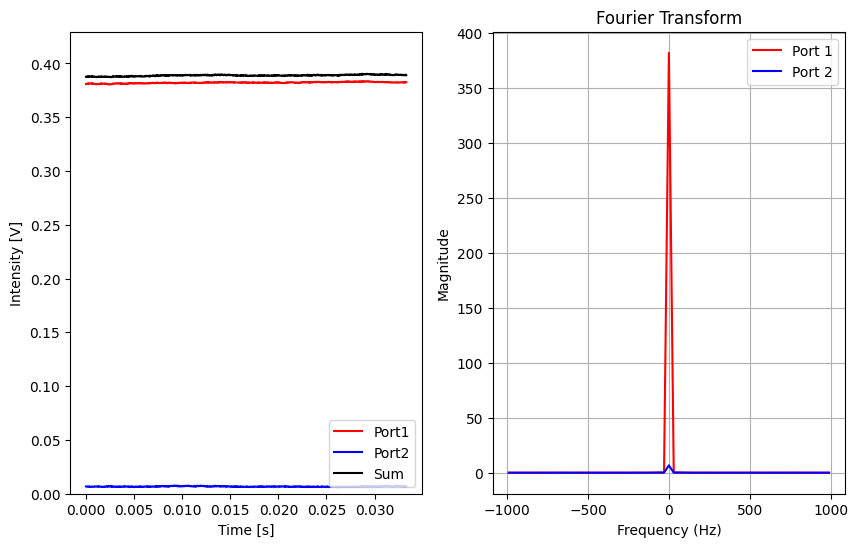

In [23]:
# 1. Generate Data from Experiment
DATA = [[] for i in range(2)]
SamplingRate = 30000
for i in range(1):
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai16")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai17")
        task.timing.cfg_samp_clk_timing(rate = SamplingRate
            
        )
        sample = 1000
        start_time = time.time()
        voltage_data =task.read(number_of_samples_per_channel=sample)
        end_time = time.time()
        frequence = sample/(end_time-start_time)
        print("Freq is :",frequence)
        print(voltage_data)
#voltage_data = voltage_data[13700:14000]
SUM = [i+j for i,j in zip(voltage_data[0],voltage_data[1])]
TIME = [i/SamplingRate for i in range(sample)]

# 2. Plot waveform on left panel
(f, (ax1, ax2)) = plt.subplots(1, 2, figsize=(10,6))


ax1.plot(TIME,voltage_data[0],color ="red",label = "Port1")
ax1.plot(TIME,voltage_data[1],color ="blue",label = "Port2")
ax1.set_ylim(0, np.max(SUM)*1.1)
ax1.plot(TIME,SUM,color="black",label = "Sum")
ax1.legend(loc='lower right', ncol=1)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Intensity [V]")

# 3. Plot Fourier Transform in right panel
def plot_fourier_transform(DATA, sample_rate):
    colors = ["red", "blue"]
    index = 0
    for data in DATA:
        # Compute the Fast Fourier Transform (FFT) of the data
        fft_result = np.fft.fft(data)
        
        # Calculate the frequency values corresponding to the FFT result
        frequencies = np.fft.fftfreq(len(data), d=1/sample_rate)
        
        # Take the absolute value to get the magnitude (amplitude) of the complex values
        magnitude = np.abs(fft_result)
        
        # Filter frequencies and magnitudes to include only the range from -2500 to 2500
        filtered_indices = np.where((frequencies >= -1000) & (frequencies <= 1000))
        filtered_frequencies = frequencies[filtered_indices]
        filtered_magnitude = magnitude[filtered_indices]
        
        # Sort the frequencies and magnitudes based on frequencies
        sorted_indices = np.argsort(filtered_frequencies)
        sorted_frequencies = filtered_frequencies[sorted_indices]
        sorted_magnitude = filtered_magnitude[sorted_indices]

        # Plot the Fourier Transform
        ax2.plot(sorted_frequencies, sorted_magnitude, color=colors[index], label="Port {}".format(index + 1))
        index += 1
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.set_title('Fourier Transform')
    ax2.grid(True)
    ax2.legend()
    
plot_fourier_transform(voltage_data,SamplingRate)
plt.show()